## Simulation of  modified Stuart-Landau (MSL) model with (generalized) phase model

### Setup

In [1]:
include("../src/GeneralizedPhaseModel.jl");
using PyCall

In [2]:
plt.rc("text", usetex=true)
PyCall.PyDict(plt."rcParams")["font.size"] = 12
PyCall.PyDict(plt."rcParams")["xtick.direction"] = "in"
PyCall.PyDict(plt."rcParams")["ytick.direction"] = "in"
PyCall.PyDict(plt."rcParams")["xtick.minor.visible"] = true
PyCall.PyDict(plt."rcParams")["ytick.minor.visible"] = true
PyCall.PyDict(plt."rcParams")["xtick.top"] = true 
PyCall.PyDict(plt."rcParams")["ytick.right"] = true 
PyCall.PyDict(plt."rcParams")["font.family"] = "Arial"
PyCall.PyDict(plt."rcParams")["text.latex.preamble"] = [raw"\usepackage{amsmath}"];

sys:1: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


### Model definition 

In [3]:
dxdt(X, I, λ=5.0) = λ*(X[1]-I) - exp(I)*X[2]-λ*((X[1]-I)^2+X[2]^2)*(X[1]-I)
dydt(X, I, λ=5.0) = exp(I)*(X[1]-I) + λ*X[2]-λ*((X[1]-I)^2+X[2]^2)*X[2]
F(X, I) = [dxdt(X, I), dydt(X, I)]

D, N = 2, 2 # number of dimensions, units
Nθ = 1000
G(X, K) = K * ((1 .- eye(N)) * X[:, 1])
dt = 1e-3; T = 100; Nt = round(Int, T/dt)
trange = range(0, T, length=Nt)
alg = Tsit5();

In [4]:
@time Ts, ω, Xs = FindStablePeriodicSolution(F, 0, D, Nθ, [1, 0], dt, alg, 2, 0.0, print_progress=false)
println("Ts=", Ts, " (sec) , ω=", ω, " (Hz)")

 10.654055 seconds (33.25 M allocations: 2.229 GiB, 5.44% gc time)
Ts=6.284 (sec) , ω=0.9998703544206853 (Hz)


In [5]:
# F, Imin, Imax, dI, D, Nθ, nothing, dt, alg, origin_val_idx, origin_thr
ωI, ζθI, ξθI, XsI = ComputeGeneralizedPhaseSensitivityFunction(F, -1.2, 1.2, 0.1, D, Nθ, nothing, dt, alg, 2, 0.0);

[1/3] Computing Xs(θ, I) and Z(θ, I)...100%|████████████| Time: 0:00:11


[2/3] Computing ζ(θ, I)...
[3/3] Computing ξ(θ, I)...


In [6]:
function coupled_func!(dX, X, p, t)
    g, κ = p
    Iext = g(X) # input
    for i in 1:size(dX)[1]
        dX[i, :] = κ[i] * F(X[i, :], Iext[i])
    end
end

coupled_func! (generic function with 1 method)

In [7]:
function all_simulation(N, D, ωI, ζθI, ξθI, XsI, coupled_func!, G, K, κ, initθ, alg=Tsit5(), NΘ=100)
    g(X) = G(X, K)
    IΘ = ComputeIsΘ(g, N, D, XsI, NΘ)
    
    Xos, Θgos, Θcos = coupled_original_system(N, D, Nt, dt, XsI, g, coupled_func!, initθ, κ, alg)
    Xcpm, Θcpm = coupled_conventinal_phase_model(N, D, Nt, dt, XsI, g, ωI, ζθI, Θcos[1, :], κ, alg)
    Xgpm, Θgpm = coupled_generalized_phase_model_I(N, D, Nt, dt, XsI, IΘ, ωI, ξθI, Θgos[1, :], κ, alg)
    return Xos, Xcpm, Xgpm, Θgos, Θcos, Θcpm, Θgpm
end

all_simulation (generic function with 3 methods)

In [8]:
K = 0.3
κs = [[1.0, 1.001], [1.0, 1.01], [1.0, 1.1]]
initθ = [0, 0];
Xoss, Xcpms, Xgpms = Any[], Any[], Any[]

@time for κ in κs
    res = all_simulation(N, D, ωI, ζθI, ξθI, XsI, coupled_func!, G, K, κ, initθ, alg)
    push!(Xoss, res[1])
    push!(Xcpms, res[2])
    push!(Xgpms, res[3])
end

Computing I₀(θ₁, θ₂)...100%|████████████████████████████| Time: 0:00:00
Computing I₀(θ₁, θ₂)...100%|████████████████████████████| Time: 0:00:00
Computing I₀(θ₁, θ₂)...100%|████████████████████████████| Time: 0:00:00


 33.437136 seconds (225.75 M allocations: 14.826 GiB, 10.78% gc time, 29.92% compilation time)


### Results

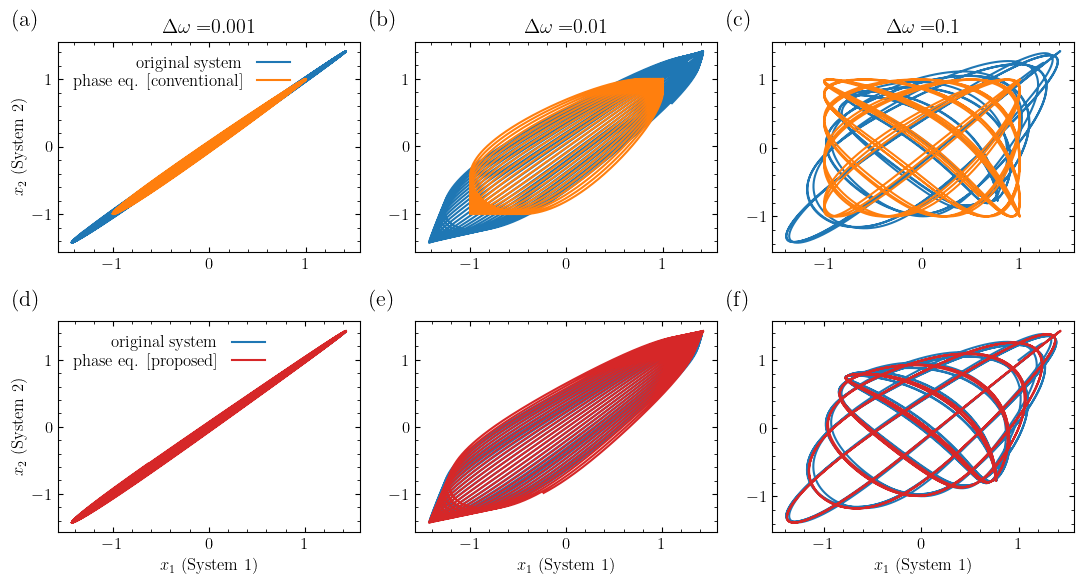

In [9]:
num_Ks = length(κs);
panel_labels = 'a':'z';

fig, axes = subplots(2, 3, figsize=(11, 6))
idx = 1:Nt
for i in 1:num_Ks
    #axes[i].set_title(L"$K=$"*string(Ks[i])*L", $\Delta \omega=$"*string(round((κ[2]-κ[1])*ω, digits=3))*L", $\Theta_0=$"*string(round.(initθ, digits=3)))
    #axes[i].plot(Xgpms[i][idx, 1, 1], Xgpms[i][idx, 2, 1], label="phase eq. [proposed]")
    #axes[2*i-1].set_ylim(-1.5, 2.5); 
    κ = κs[i]
    axes[2*i-1].set_title(L"$\Delta \omega=$"*string(round((κ[2]-κ[1])*ω, digits=3))); 
    if i == 1
        axes[2*i-1].set_ylabel(L"$x_2$ (System 2)"); 
        axes[2*i-1].plot(Xoss[i][idx, 1, 1], Xoss[i][idx, 2, 1], color="tab:blue", label="original system")
        axes[2*i-1].plot(Xcpms[i][idx, 1, 1], Xcpms[i][idx, 2, 1], color="tab:orange", label="phase eq. [conventional]")
        axes[2*i-1].legend(loc="upper left", ncol=1, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)
    else
        axes[2*i-1].plot(Xoss[i][idx, 1, 1], Xoss[i][idx, 2, 1], color="tab:blue")
        axes[2*i-1].plot(Xcpms[i][idx, 1, 1], Xcpms[i][idx, 2, 1], color="tab:orange")
    end
    #axes[2*i-1].set_xlabel(L"$x_1$ (System 1)"); axes[2*i-1].set_ylabel(L"$x_2$ (System 2)"); 
    axes[2*i-1].text(-0.15, 1.15, "("*string(panel_labels[i])*")", fontsize=16, transform=axes[2*i-1].transAxes, fontweight="bold", va="top")
    #axes[i].set_title(L"$K=$"*string(Ks[i])*L", $\Delta \omega=$"*string(round((κ[2]-κ[1])*ω, digits=3))*L", $\Theta_0=$"*string(round.(initθ, digits=3)))
    #axes[2*i].set_ylim(-1.5, 2.5); 
    if i == 1
        axes[2*i].set_ylabel(L"$x_2$ (System 2)"); 
        axes[2*i].plot(Xoss[i][idx, 1, 1], Xoss[i][idx, 2, 1], color="tab:blue", label="original system")
        axes[2*i].plot(Xgpms[i][idx, 1, 1], Xgpms[i][idx, 2, 1], color="tab:red", label="phase eq. [proposed]")
        axes[2*i].legend(loc="upper left", ncol=1, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)
    else
        axes[2*i].plot(Xoss[i][idx, 1, 1], Xoss[i][idx, 2, 1], color="tab:blue")
        axes[2*i].plot(Xgpms[i][idx, 1, 1], Xgpms[i][idx, 2, 1], color="tab:red")
    end
    axes[2*i].set_xlabel(L"$x_1$ (System 1)");
    axes[2*i].text(-0.15, 1.15, "("*string(panel_labels[i+3])*")", fontsize=16, transform=axes[2*i].transAxes, fontweight="bold", va="top")
end
tight_layout()
savefig("fig2.svg")